In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist

points = np.array([
    [2, 10],  # A1
    [4, 9],   # A2
    [5, 8],   # A3
    [5, 9],   # A4
    [8, 5],   # A5
    [8, 4],   # A6
    [7, 5],   # A7
    [6, 4],   # A8
    [7, 4]    # A9
])
labels = ['A1','A2','A3','A4','A5','A6','A7','A8','A9']
print(f'Points chargés: {points.shape[0]} éléments')

Points chargés: 9 éléments


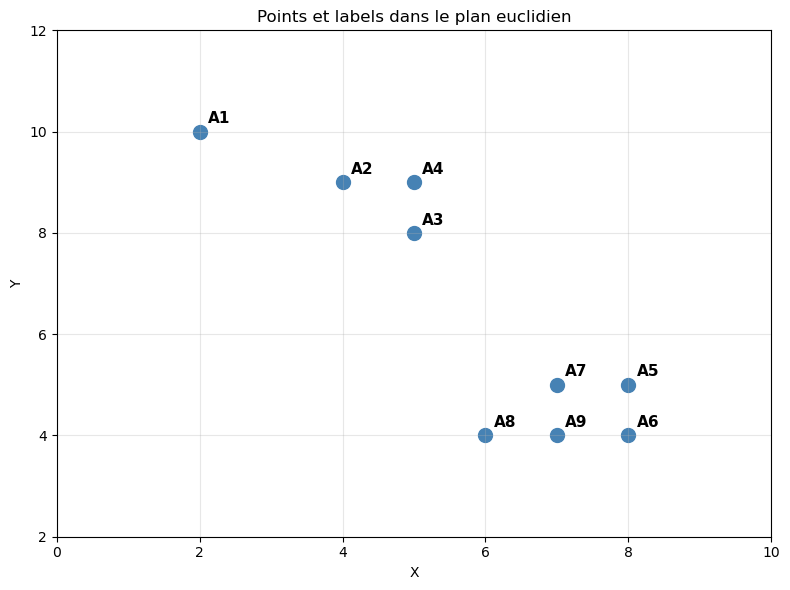

In [9]:
# Schématisation sur le plan euclidien
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(points[:,0], points[:,1], c='steelblue', s=100)
for i, lbl in enumerate(labels):
    ax.annotate(lbl, (points[i,0], points[i,1]), xytext=(6,6), textcoords='offset points', fontsize=11, fontweight='bold')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Points et labels dans le plan euclidien')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 10)
ax.set_ylim(2, 12)
plt.tight_layout()
plt.show()

## Configurations testées
- Métriques: 'cityblock' (Manhattan), 'euclidean'
- Liaisons: 'single', 'complete', 'average'
- Seuils: [1.5, 2.0, √5, 3.0, 4.0, 5.0]

In [10]:
configs = [{'metric': m, 'method': l} for m in ['cityblock','euclidean'] for l in ['single','complete','average']]
thresholds = [1.5, 2.0, float(np.sqrt(5)), 3.0, 4.0, 5.0]
configs, thresholds

([{'metric': 'cityblock', 'method': 'single'},
  {'metric': 'cityblock', 'method': 'complete'},
  {'metric': 'cityblock', 'method': 'average'},
  {'metric': 'euclidean', 'method': 'single'},
  {'metric': 'euclidean', 'method': 'complete'},
  {'metric': 'euclidean', 'method': 'average'}],
 [1.5, 2.0, 2.23606797749979, 3.0, 4.0, 5.0])

## Mesures d'évaluation
- Intra-cluster (moyenne des distances intra): plus petit est meilleur
- Inter-centroid (distance moyenne entre centroïdes): plus grand est meilleur
- Score = inter_centroid_mean − intra_mean

In [11]:
from itertools import combinations

def intra_cluster_mean(points, assignment, metric='cityblock'):
    def dist(a,b):
        return np.abs(a-b).sum() if metric=='cityblock' else np.linalg.norm(a-b)
    values = []
    for cid in sorted(set(assignment)):
        idx = [i for i,c in enumerate(assignment) if c==cid]
        if len(idx) < 2:
            continue
        dists = [dist(points[i], points[j]) for i,j in combinations(idx,2)]
        if dists:
            values.append(float(np.mean(dists)))
    return float(np.mean(values)) if values else 0.0

def inter_cluster_centroid_mean(points, assignment, metric='cityblock'):
    def dist(a,b):
        return np.abs(a-b).sum() if metric=='cityblock' else np.linalg.norm(a-b)
    centroids = []
    for cid in sorted(set(assignment)):
        idx = [i for i,c in enumerate(assignment) if c==cid]
        centroids.append(points[idx].mean(axis=0))
    if len(centroids) < 2:
        return 0.0
    dists = [dist(centroids[i], centroids[j]) for i,j in combinations(range(len(centroids)),2)]
    return float(np.mean(dists))

## Calcul des résultats pour toutes les combinaisons

In [12]:
rows = []
for cfg in configs:
    D = pdist(points, metric=cfg['metric'])
    Z = linkage(D, method=cfg['method'])
    for th in thresholds:
        assignment = fcluster(Z, th, criterion='distance')
        intra = intra_cluster_mean(points, assignment, metric=cfg['metric'])
        interc = inter_cluster_centroid_mean(points, assignment, metric=cfg['metric'])
        rows.append({
            'metric': cfg['metric'],
            'method': cfg['method'],
            'threshold': th,
            'clusters': int(len(set(assignment))),
            'intra_mean': intra,
            'inter_centroid_mean': interc,
            'score': float(interc - intra)
        })
df_results = pd.DataFrame(rows)
df_results = df_results.sort_values(['metric','method','threshold']).reset_index(drop=True)
print(f'Resultats générés: {len(df_results)} lignes')
df_results.head(10)

Resultats générés: 36 lignes


,metric,method,threshold,clusters,intra_mean,inter_centroid_mean,score
0,cityblock,average,1.500000,4,1.222222,6.805556,5.583333
1,cityblock,average,2.000000,3,1.466667,7.200000,5.733333
2,cityblock,average,2.236068,3,1.466667,7.200000,5.733333
3,cityblock,average,3.000000,3,1.466667,7.200000,5.733333
4,cityblock,average,4.000000,2,2.133333,7.800000,5.666667
5,cityblock,average,5.000000,2,2.133333,7.800000,5.666667
6,cityblock,complete,1.500000,6,1.000000,5.900000,4.900000
7,cityblock,complete,2.000000,4,1.222222,6.805556,5.583333
8,cityblock,complete,2.236068,4,1.222222,6.805556,5.583333
9,cityblock,complete,3.000000,3,1.466667,7.200000,5.733333


## Tableau complet des résultats

In [13]:
df_results

,metric,method,threshold,clusters,intra_mean,inter_centroid_mean,score
0,cityblock,average,1.500000,4,1.222222,6.805556,5.583333
1,cityblock,average,2.000000,3,1.466667,7.200000,5.733333
2,cityblock,average,2.236068,3,1.466667,7.200000,5.733333
3,cityblock,average,3.000000,3,1.466667,7.200000,5.733333
4,cityblock,average,4.000000,2,2.133333,7.800000,5.666667
5,cityblock,average,5.000000,2,2.133333,7.800000,5.666667
6,cityblock,complete,1.500000,6,1.000000,5.900000,4.900000
7,cityblock,complete,2.000000,4,1.222222,6.805556,5.583333
8,cityblock,complete,2.236068,4,1.222222,6.805556,5.583333
9,cityblock,complete,3.000000,3,1.466667,7.200000,5.733333


## Sélection de la meilleure configuration

In [14]:
best_row = df_results.sort_values('score', ascending=False).iloc[0]
best_metric = best_row['metric']
best_method = best_row['method']
best_threshold = float(best_row['threshold'])
print(f"Meilleure configuration: metric={best_metric}, method={best_method}, threshold={best_threshold}")
best_row

Meilleure configuration: metric=cityblock, method=average, threshold=2.0


metric                 cityblock
method                   average
threshold                    2.0
clusters                       3
intra_mean              1.466667
inter_centroid_mean          7.2
score                   5.733333
Name: 1, dtype: object

## Dendrogramme et clusters pour la meilleure configuration

Cluster 1: A5, A6, A7, A8, A9
Cluster 2: A2, A3, A4
Cluster 3: A1


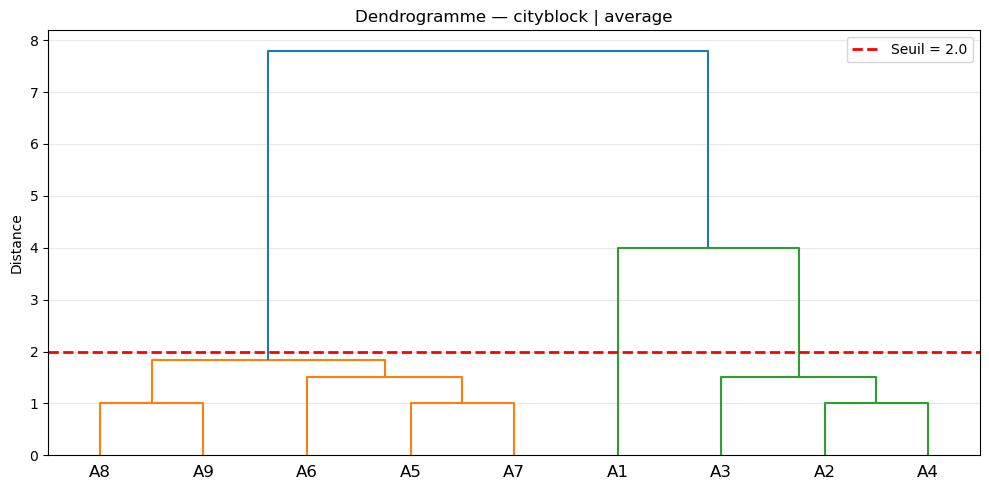

In [15]:
D_best = pdist(points, metric=best_metric)
Z_best = linkage(D_best, method=best_method)
assignment_best = fcluster(Z_best, best_threshold, criterion='distance')

# Afficher les clusters
for cid in sorted(set(assignment_best)):
    members = [labels[i] for i,c in enumerate(assignment_best) if c==cid]
    print(f"Cluster {cid}: {', '.join(members)}")

# Dendrogramme
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
dendrogram(Z_best, labels=labels, ax=ax)
ax.axhline(y=best_threshold, color='r', linestyle='--', linewidth=2, label=f'Seuil = {best_threshold}')
ax.set_title(f"Dendrogramme — {best_metric} | {best_method}")
ax.set_ylabel('Distance')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## Conclusion
- La métrique 'cityblock' est souvent plus cohérente avec des données alignées sur une grille (Manhattan).
- La liaison 'single' privilégie les connexions locales; 'complete' favorise la compacité; 'average' équilibre les deux.
- La meilleure configuration est sélectionnée via le score combiné inter − intra; ajustez le seuil pour contrôler le nombre de clusters.

# Clusters à distance de séparation > √5 (Manhattan, single)

Cette section spécifie explicitement les clusters au seuil √5 avec `metric='cityblock'` et `method='single'`, conformément à l'énoncé.


Seuil choisi: √5 ≈ 2.2361
Clusters au seuil √5 (cityblock, single):
- Cluster 1: A5, A6, A7, A8, A9
- Cluster 2: A2, A3, A4
- Cluster 3: A1


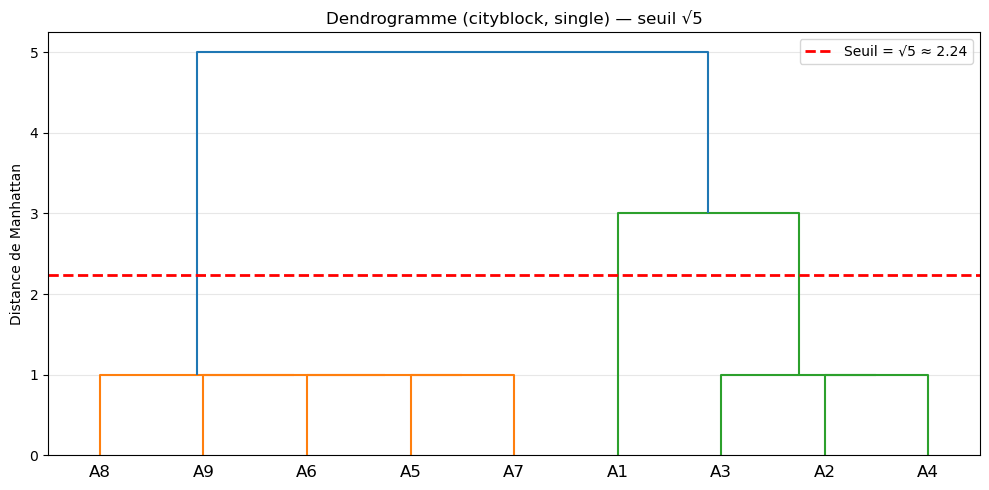

In [16]:
# Calcul et visualisation au seuil √5
import numpy as np
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import matplotlib.pyplot as plt

sqrt5 = float(np.sqrt(5))
D_manhattan = pdist(points, metric='cityblock')
Z_single = linkage(D_manhattan, method='single')
assign_sqrt5 = fcluster(Z_single, sqrt5, criterion='distance')

print(f"Seuil choisi: √5 ≈ {sqrt5:.4f}")
print("Clusters au seuil √5 (cityblock, single):")
for cid in sorted(set(assign_sqrt5)):
    members = [labels[i] for i,c in enumerate(assign_sqrt5) if c==cid]
    print(f"- Cluster {cid}: {', '.join(members)}")

fig, ax = plt.subplots(1,1, figsize=(10,5))
dendrogram(Z_single, labels=labels, ax=ax)
ax.axhline(y=sqrt5, color='r', linestyle='--', linewidth=2, label=f'Seuil = √5 ≈ {sqrt5:.2f}')
ax.set_title('Dendrogramme (cityblock, single) — seuil √5')
ax.set_ylabel('Distance de Manhattan')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()